# Universidad de Chile
### Facultad de Ciencias, Física y Matemáticas
### Departamento de Ciencias de la Computación
### CC5509 - Reconocimiento de Patrones
### Tarea 2 - Optical Character Recognition usando Histogramas de Orientaciones y MultiLayer Perceptron (MLP)
### Gabriel De La Parra

# Introducción
En esta tarea se implementará un OCR para reconocer digitos numéricos utilizando una red neuronal. 

Al igual que en la tarea 1, se trabajará con digitos provenientes de un RUT Chileno. 

Esta tarea se implementó en Jupyter Notebook con Python, debido a la facilidad para ejecutar código, crear un informe y mostrar los resultados en un mismo documento.

La tarea consiste en entrenar una red neuronal de varias capas (MultiLayer Perceptron) para reconocer dígitos. Este tipo de problemas, de determinar un tipo particular de caso, se le conoce como clasificación. 

## Procedimiento

El primer paso para este proyecto consiste en entrenar la red. El entrenamiento de la red consiste en entregarle a la red un conjunto de ejemplos de entrada, indicándole a que corresponde cada ejemplo. Adicional a lo anterior se define la cantidad de capas de la red y algunos parámetros típicos de una red neuronal.

Los ejemplos que se entregarán a la red, en esta tarea se entregarán de dos formas:
1. Histograma de orientaciones (Tarea 1).
2. Imagen Binaria Vectorizada y reducida.

El histograma de orientaciones, como se vió en la tarea 1, consiste en calcular, para cada pixel, el ángulo y la magnitud de la orientación de cambios entre los pixeles vecinos. En dicha tarea se trabajó convirtiendo cada dígito de las imágenes a 16x10 pixeles, posteriormente trabajando con 4 celdas por imagen. Se trabajará de la misma manera para procesar las imágenes con este método.

Con respecto al segundo método, el procesamiento es más sencillo. Se convertirá la imagen a 28x28 pixeles y posteriormente se convertirá a un arreglo plano, sin ningún procesamiento más que la binarización.

Con ambos métodos se procederá a entrenar la red neuronal. Una vez entrenada la red, se guardará el modelo y posteriormente se utilizará para clasificar los dígitos de un RUT.

Dado lo anterior, el procedimiento que se utilizará es el siguiente:
1. Entrenar la red neuronal
    - Procesar las imágenes de entrada según:
        - Histograma de Orientaciones
        - Vector de Imagen Binarizada
    - Entrenar y validar un modelo con distintos parámetros:
        - Cantidad de neuronas ocultas: 
            - 10
            - 20
            - 30
            - 40
            - 50
        - Función de activación:
            - Sigmoidal
            - TanH
            - RELU
2. Guardar el modelo entrenado usando joblib de sklearn.externals
3. Clasificar los dígitos de la imagen

# Imports

In [1]:
# Tarea 1
import numpy as np
import math
import os
from scipy import ndimage, signal, misc
from skimage import io, morphology, filters, segmentation, measure, color
from matplotlib import pyplot as plt, patches
%matplotlib inline

# Tarea 2
from sklearn.neural_network import MLPClassifier
from sklearn.externals import  joblib

# Refactor Tarea 1
En esta parte se trabajará sobre los resultados de la tarea 1. Se extraerán los métodos para el procesamiento de los dígitos que crean los histogramas de orientaciones. 

Se ha hecho una modificación sobre la tarea anterior, dejando 2x2 celdas por cada imagen (En la tarea anterior se trabajó con 4x4), el procesamiento era mayor, pero en este caso los resultados son más apropiados para el trabajo con todas las imágenes.

El procesamiento de los dígitos da como resultado un vector de 36 valores, correspondiente a los 9 bins por 4 celdas en cada imagen. 

Otra mejora, fue agregar un threshold para aceptar un valor en magnitud. Si la magnitud de cambio entre 2 pixeles no es mayor que dicho umbral, no se toma ese pixel para el histograma. Esto fue una recomendación del profesor.

Como se mencionó anteriormente, las imágenes se han reducido a 16x16 para acelerar el proceso de procesamiento en la fase de pruebas. Esto solo para la primera parte del informe, para la versión final, se trabajará con el tamaño completo de la imagen.

In [2]:
maskX = [[-1, 0, 1]]
maskY = [[-1], [0], [1]]

In [3]:
def getOrientAndMags(image):
    gradX = signal.convolve(image, maskX, mode = 'same')
    gradY = signal.convolve(image, maskY, mode = 'same')
    o = (np.arctan2(gradY, gradX)  * 180 / np.pi) %360
    m = np.sqrt(gradY**2 + gradX**2)
    return o, m

In [25]:
def histogram(image, kBins, assignment = "soft", threshold = 0.5):
    hist = np.zeros(kBins, dtype=np.float32)
    w, h = image.shape
    
    o, m = getOrientAndMags(image)
    maxVal = np.max(m) * np.max(o)
    
    for i in range(w):
        for j in range(h):
            # Skip those with magnitude lower than 'threshold'.
            if(m[i,j] > threshold):
                calc = (o[i,j] * m[i,j])
                if(assignment == "hard"):
                    kbin = int(round(calc/maxVal*(kBins-1)))
                    hist[kbin] += 1.0
                else:
                    b = calc/maxVal*(kBins-1)
                    if(math.isnan(b)):
                        b = 0
                    dist = b - math.floor(b)
                    lbin = math.floor(b)
                    rbin = math.ceil(b)
                    if(dist < 0.5):
                        lw = 0.5 - dist
                        rw = 1-lw
                    else:
                        rw = dist - 0.5
                        lw = 1 - rw
                    hist[lbin] += lw
                    hist[rbin] += rw
    return hist

In [26]:
def fixImagePadding(image, cellSize = (4,4)):
    w, h = image.shape
    cX, cY = cellSize
    padX = cX - (w % cX)
    padY = cY - (h % cY)
    if(padX == cX): padX = 0
    if(padY == cY): padY = 0
    paddedImage = np.zeros((w+padX, h+padY))
    paddedImage.fill(255)
    for x in range(w):
        for y in range(h):
            paddedImage[x,y] = image[x,y]
    return paddedImage

In [27]:
def getImageCells(image, cellSize = (4,4)):
    cells = []
    w, h = image.shape
    cX, cY = cellSize
    for x in range(int(w/cX)):
        for y in range(int(h/cY)):
            cells.append(image[x*cX:((x+1)*cX), y*cY:((y+1)*cY)])

    return cells  

In [28]:
def concatenateCellsDescriptors(cells, bins = 9):
    concat = []
    for cell in cells:
        hist = histogram(cell, bins, assignment = "soft")
        for h in hist:
            concat.append(h)
    return concat

In [29]:
def plotCellDescriptors(concat, cells):
    plt.figure(figsize=(30,10))
    concat = concatenateCellsDescriptors(cells)
    plt.bar(np.arange(len(concat)), concat)
    plt.show()

In [63]:
def resizeAndGetDigitHistogramDescriptor(digitFilename, w, h, cW, cH, verbose = True):
    digit=io.imread(digitFilename)
    digitImage = digit
    if(w>0 and h >0):
        digit = misc.imresize(digit, (w, h))
    digit = fixImagePadding(digit, (cW, cH))
    cells = getImageCells(digit, (cW, cH))
    concat = concatenateCellsDescriptors(cells)
    
    if(verbose):
        plt.imshow(digit, cmap="gray")
        print("ImageFilename:", digitFilename)
        print("original:", digitImage.shape, "Resize and padded:", digit.shape)
        print("Concatenated histogram length:", len(concat))
        plotCellDescriptors(concat, cells)
    
    return np.array(concat), cells

ImageFilename: ./digits_K/train/chr_0/img001-00001.png
original: (128, 128) Resize and padded: (16, 16)
Concatenated histogram length: 36


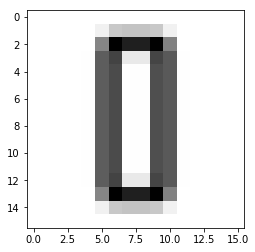

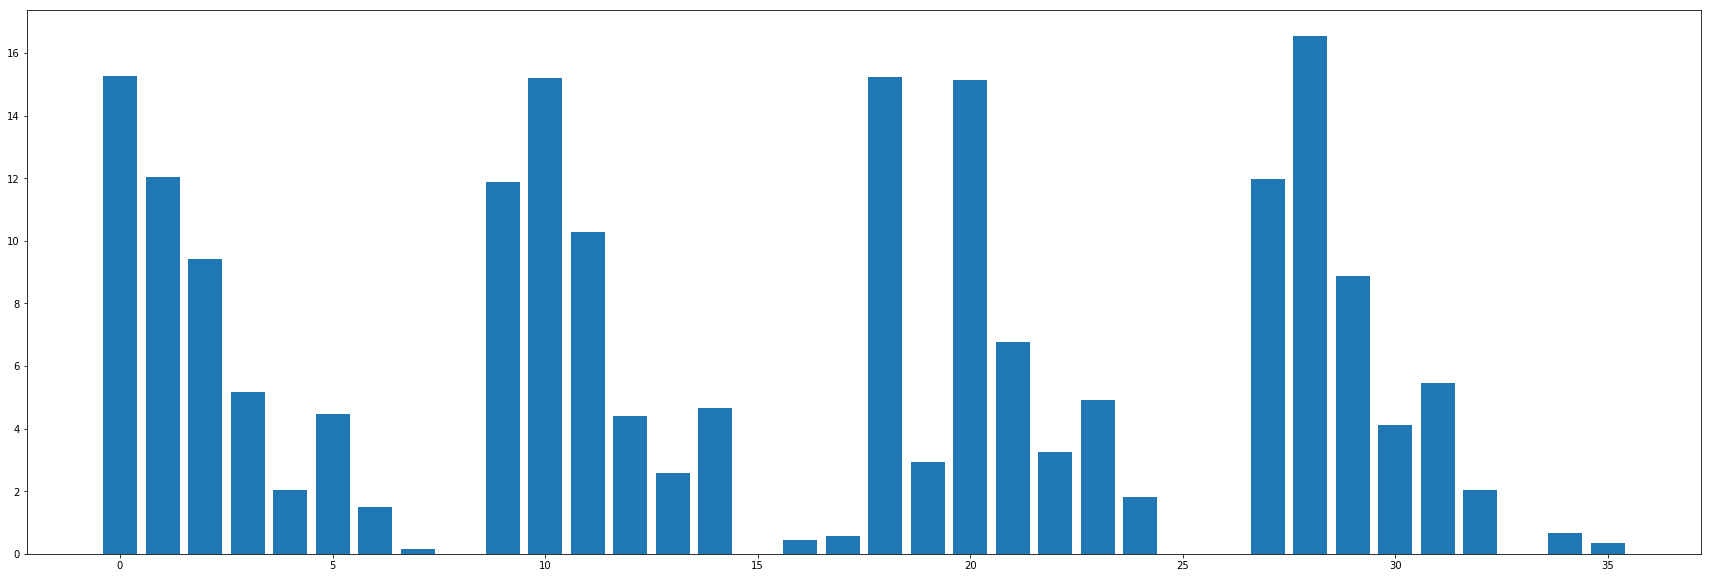

In [64]:
sampleDigitFilename = "./digits_K/train/chr_0/img001-00001.png"
concat, cells = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 16, 16, 8, 8, verbose = True)

In [60]:
concat, _ = resizeAndGetDigitHistogramDescriptor(sampleDigitFilename, 16, 16, 8, 8, verbose = False)
concat

array([ 15.26013088,  12.02977657,   9.40496063,   5.18296337,
         2.0250411 ,   4.4582696 ,   1.4830246 ,   0.15583272,
         0.        ,  11.88395691,  15.21132946,  10.27912235,
         4.39615154,   2.56636167,   4.66307974,   0.        ,
         0.43440887,   0.56559116,  15.22864342,   2.92289186,
        15.12734509,   6.76401901,   3.25150323,   4.89886761,
         1.80673158,   0.        ,   0.        ,  11.97495174,
        16.53761292,   8.88857746,   4.10198212,   5.45810413,
         2.03877211,   0.        ,   0.66784531,   0.33215469], dtype=float32)

# Imagen a Vector Binarizado
Se convertirá a la imagen a 28x28 pixeles, se aplicará un Threshold Otsu y se hará un Reshape a un vector de una sola fila.

In [48]:
def getImageVector(digitFilename, w = 28, h = 28):
    digitImage=io.imread(digitFilename)
    digit = misc.imresize(digitImage, (w, h))
    th=filters.threshold_otsu(digit*0.95)
    digit = digit > th
    return np.reshape(digit, w*h)

In [66]:
sampleDigitFilename = "./digits_K/train/chr_0/img001-00001.png"
getImageVector(sampleDigitFilename)[0:100]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False, False], dtype=bool)

# Entrenamiento de la MLP
Una vez que se tiene completo el procesamiento de los dígitos, será necesario entrenar la Red Neuronal.

## Get Training Images

In [75]:
def getfiles(folder, extension):
    images = []
    for dirpath, dirnames, filenames in os.walk(folder):
        for filename in [f for f in filenames if f.endswith(extension)]:
            images.append(os.path.join(dirpath, filename))
    return images

In [77]:
def getTrainFiles():
    return getfiles("./digits_K/train/", ".png")

def getValidFiles():
    return getfiles("./digits_K/valid/", ".png")

In [81]:
trainImageFilenames = getTrainFiles()
validImageFilenames = getValidFiles()
print("Train:", len(trainImageFilenames), "Valid:", len(validImageFilenames))

Train: 6600 Valid: 2200


In [89]:
trainImageFilenames[0]

'./digits_K/train/chr_0\\img001-00001.png'

## Create Labels for Test/Valid Images

In [119]:
def getImageLabel(filename, index):
    return filename[index]

def getTestImageLabel(filename):
    return getImageLabel(filename, 21)

def getValidImageLabel(filename):
    return getImageLabel(filename, 21)

In [193]:
def toLabelVector(labels):
    b = np.zeros((len(labels), max(labels).+1))
    b[np.arrange(len(labels)), labels] = 1
    return b    

In [194]:
train_target = list(getTestFileLabels(trainImageFilenames))
train_target

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0'

In [195]:
toLabelVector(train_target)

AttributeError: 'list' object has no attribute 'max'

## Assemble Test Set

In [174]:
def getFileSet(filenames, function):
    for filename in filenames:
        result = function(filename)
        yield result

def getHistogram(filename):
    concat, _ = resizeAndGetDigitHistogramDescriptor(filename, 16, 16, 4, 4, verbose = False)
    return concat

def getHistogramFileSet(filenames):
    return getFileSet(filenames, getHistogram)

def getVectorFileSet(filenames):
    return getFileSet(filenames, getImageVector)

def getTestFileLabels(filenames):
    return getFileSet(filenames, getTestImageLabel)

def getValidFileLabels(filenames):
    return getFileSet(filenames, getValidImageLabel)

In [175]:
train_data = list(getHistogramFileSet(trainImageFilenames))
train_target = list(getTestFileLabels(trainImageFilenames))
#test_data = list(getVectorFileSet(validImageFilenames))
#test_target = list(getValidFileLabels(validImageFilenames))

In [182]:
mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(100,), max_iter=500, alpha=1e-4, solver='sgd', verbose=10, tol=1e-4, learning_rate_init=.01)

In [183]:
mlp.fit(train_data, train_target)

Iteration 1, loss = 1.71696619
Iteration 2, loss = 0.72791425
Iteration 3, loss = 0.52916090
Iteration 4, loss = 0.44875023
Iteration 5, loss = 0.40190647
Iteration 6, loss = 0.37002856
Iteration 7, loss = 0.34188137
Iteration 8, loss = 0.32642259
Iteration 9, loss = 0.30697903
Iteration 10, loss = 0.29366395
Iteration 11, loss = 0.27931422
Iteration 12, loss = 0.27109479
Iteration 13, loss = 0.26120812
Iteration 14, loss = 0.25423576
Iteration 15, loss = 0.24395691
Iteration 16, loss = 0.23866213
Iteration 17, loss = 0.23174557
Iteration 18, loss = 0.22543533
Iteration 19, loss = 0.22068982
Iteration 20, loss = 0.21387672
Iteration 21, loss = 0.21005674
Iteration 22, loss = 0.20628921
Iteration 23, loss = 0.19957901
Iteration 24, loss = 0.19751883
Iteration 25, loss = 0.18998063
Iteration 26, loss = 0.18824507
Iteration 27, loss = 0.18324835
Iteration 28, loss = 0.18179664
Iteration 29, loss = 0.17746209
Iteration 30, loss = 0.17447356
Iteration 31, loss = 0.17017188
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=10, warm_start=False)

In [143]:
imageFilename = "./test-images/rut_1.png"

In [12]:
image=io.imread(imageFilename)

In [13]:
def getSliceTupleArea(sliceTuple):
    return (sliceTuple[0].stop - sliceTuple[0].start) * (sliceTuple[1].stop - sliceTuple[1].start)

In [14]:
def getImageDigits(imageFilename):
    digits = []
    #Read
    image=io.imread(imageFilename)
    #im_bin = np.zeros_like(image)
    
    #Threshold
    th=filters.threshold_otsu(image*0.95)
    im_bin = image > th
    
    #Regions:
    mlabels, nlabels = morphology.label(1-im_bin, connectivity=1, return_num=True)
    regions = measure.regionprops(mlabels)
    
    #Regions of Interest
    roiList = []
    for i in range(1, nlabels + 1):
        px, py = ndimage.find_objects(mlabels==i)[0]
        roiList.append((px,py))
        
    #Sort regions by position:
    sortedRoi = sorted(roiList, key= lambda x: x[1])
    
    # Filter small Regions, Pad results:
    for j in range(nlabels):
        (px, py) = sortedRoi[j]
        if(getSliceTupleArea((px,py))>15):
            roi = im_bin[px, py].astype(int)*255
            digits.append(roi)
    
    #return
    return digits

In [15]:
def getDigitsHistogramResize(imageFilename, w, h):
    hist = []    
    digits = getImageDigits(imageFilename)
    for digit in digits:
        digit = misc.imresize(digit, (w, h))
        paddedImage = fixImagePadding(digit)
        cells = getImageCells(paddedImage)
        concat = concatenateCellsDescriptors(cells)
        hist.append(concat)
    return hist, digits

In [16]:
def euclideanDistance(x1, x2, length):
    dist = 0
    for x in range(length):
        dist += pow((x1[x] - x2[x]), 2)
    return math.sqrt(dist)